In [38]:
%matplotlib inline
import os

from pprint import pprint
import numpy as np
import pandas as pd
from planet import api
import matplotlib.pyplot as plt

In [23]:
client = api.Client()

In [24]:
mosaics = client.list_mosaics().get()

In [25]:
[m['name'] for m in mosaics['mosaics']]

[u'landsat8_toa_rgb_mosaic',
 u'open_california_planetscope_mosaic',
 u're_california_summer_mosaic',
 u'open_california_hybrid_mosaic',
 u'open_california_re_20130901_20131130',
 u'open_california_re_20131201_20140228',
 u'open_california_re_20140101_20141231',
 u'open_california_re_20140301_20140531',
 u'open_california_re_20140601_20140831',
 u'open_california_re_20140901_20141130',
 u'open_california_re_20141201_20150228',
 u'open_california_re_20150101_20151231',
 u'open_california_re_20150301_20150531',
 u'open_california_re_20150601_20150831']

In [26]:
mosaic = client.get_mosaic('open_california_re_20150601_20150831')
mosaic.get()

{u'coordinate_system': u'EPSG:3857',
 u'datatype': u'uint16',
 u'first_acquired': u'2015-06-11T00:00:00+00:00',
 u'geometry': {u'coordinates': [[[-124.551309208076, 32.3817750302967],
    [-124.551309208076, 42.1341418694333],
    [-113.945370784834, 42.1341418694333],
    [-113.945370784834, 32.3817750302967],
    [-124.551309208076, 32.3817750302967]]],
  u'type': u'Polygon'},
 u'last_acquired': u'2015-08-31T23:59:59.999999+00:00',
 u'level': 15,
 u'links': {u'quadmap': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quad-map.png',
  u'quads': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/',
  u'self': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831',
  u'tiles': u'https://tiles{0-3}.planet.com/v0/mosaics/open_california_re_20150601_20150831/{z}/{x}/{y}.png'},
 u'name': u'open_california_re_20150601_20150831',
 u'quad_pattern': u'L{glevel:d}-{tilex:04d}E-{tiley:04d}N',
 u'quad_size': 4096,
 u'resolutio

In [27]:
location = {"type":"Point","coordinates":[-123.79394531249999,39.291797043774864]}
client.get_mosaic_quads('open_california_re_20150601_20150831',
                        intersects=location).get()

{u'features': [{u'geometry': {u'coordinates': [[[-123.925781233,
       39.3682791446],
      [-123.925781233, 39.2322531372],
      [-123.749999983, 39.2322531372],
      [-123.749999983, 39.3682791446],
      [-123.925781233, 39.3682791446]]],
    u'type': u'Polygon'},
   u'id': u'L15-0319E-1267N',
   u'properties': {u'links': {u'full': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N/full',
     u'mosaic': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831',
     u'scenes': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N/scenes/',
     u'self': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N',
     u'thumbnail': u'https://api.planet.com/v0/mosaics/open_california_re_20150601_20150831/quads/L15-0319E-1267N/thumb'},
    u'num_input_scenes': 6,
    u'percent_covered': 100.0,
    u'updated': u'2016-03-04T04:07:48.539853+00:00'}

In [41]:
points = np.load('/Users/ajmendez/tmp/world/coast_points.np.npy')
downloaded = []

In [46]:
mosaic_name = 'open_california_re_20150601_20150831'

outdir = '/Users/ajmendez/tmp/world/planet/{}'.format(mosaic_name)
if not os.path.exists(outdir):
    os.makedirs(outdir)
callback = api.write_to_file(outdir)

for point in points:
    location = {"type":"Point","coordinates":list(point)}
    quad = client.get_mosaic_quads(mosaic_name, intersects=location).get()
    for q in quad['features']:
        qid = q['id']
        if qid in downloaded:
            continue
        downloaded.append(qid)
        bodies = client.fetch_mosaic_quad_geotiffs(mosaic_name, [qid], callback=callback)
        for i,b in enumerate(bodies):
            b.await()
            print i, qid
    break

In [ ]:
p

In [70]:
outlines = {}
for i,point in enumerate(points):
    location = {"type":"Point","coordinates":list(point)}
    quad = client.get_mosaic_quads(mosaic_name, intersects=location).get()
    for q in quad['features']:
        qid = q['id']
        if qid in outlines:
            continue
        
        outlines[qid] = (q['geometry']['coordinates'][0])
    break
#     if len(outlines) > 2:
#         break

In [ ]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]
# for i, chunk in enumerate(chunks(points, 600)):
#     print i, len(chunk)

In [98]:
for i, chunk in enumerate(chunks(points[::-1], 100)):
    location = {"type":"LineString","coordinates":[list(p) for p in chunk]}
    quads = client.get_mosaic_quads(mosaic_name, intersects=location).get()
    for q in quads['features']:
        qid = q['id']
        if qid in outlines:
            continue
        outlines[qid] = (q['geometry']['coordinates'][0])

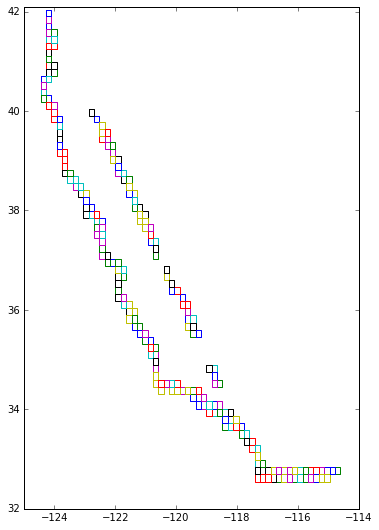

In [99]:
plt.figure(figsize=(6,9))
plt.xlim(-125, -114)
plt.ylim(32, 42.1)
for key, outline in outlines.iteritems():
    x,y = zip(*outline)
    plt.plot(x,y)

In [ ]:
for i, oids in enumerate(chunks(outlines.keys(), 10)):
    quads = client.fetch_mosaic_quad_geotiffs(mosaic_name, oids, callback=callback)
    quads = client.
    for q in quads:
        q.await()

In [1]:
# outlines

In [ ]:
s